'AAPL', 'MSFT', 'TSM', 'QCOM', 'AVGO', 'QQQ'

we tried to change architecture. now we try to add more data.

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 0.0425
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0021
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0014
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0011
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0011
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0010
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0010
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0012
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0012
Epoch 10/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0011
Epoch 11/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 8.5568e-04
Epoch 12/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 9.3571e-04
Epoch 13/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 8.3392e-04
Epoch 14/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 7.3951e-04
Epoch 15/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - l

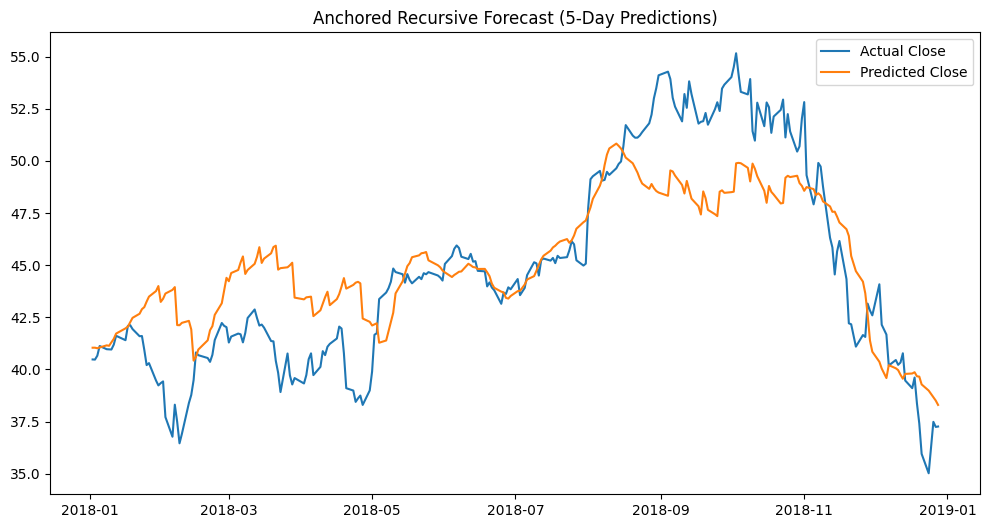

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

# ---------------------- Load & Preprocess AAPL -----------------------
def load_main_stock(path):
    df = pd.read_csv(path, skiprows=3, header=None)
    df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].set_index('Date')
    df = df.loc['2008-01-01':'2024-12-31']

    df['Close_lag1'] = df['Close'].shift(1)
    df['Volume_lag1'] = df['Volume'].shift(1)
    df['ma_5'] = df['Close_lag1'].rolling(window=5).mean()
    df['volatility_63'] = df['Close_lag1'].rolling(window=63).std()
    df['intraday_range'] = df['High'].shift(1) - df['Low'].shift(1)
    df['upper_shadow'] = df['High'].shift(1) - df[['Open', 'Close']].shift(1).max(axis=1)
    df['lower_shadow'] = df[['Open', 'Close']].shift(1).min(axis=1) - df['Low'].shift(1)
    df['momentum_126'] = df['Close_lag1'] - df['Close_lag1'].shift(126)

    df = df.drop(columns=['Open', 'High', 'Low', 'Volume'])
    return df

# ---------------------- Load Related Stocks -----------------------
def load_related_stock(path, prefix):
    df = pd.read_csv(path, skiprows=3, header=None)
    df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df = df.set_index('Date')
    df = df.loc['2008-01-01':'2024-12-31']
    df = df[['Close']]
    df[f'{prefix}_lag1'] = df['Close'].shift(1)
    df = df.drop(columns=['Close'])
    return df

# Main AAPL
df = load_main_stock("AAPL.csv")

# Add related stocks
related_stocks = ['MSFT', 'TSM', 'QCOM', 'AVGO', 'QQQ']
for stock in related_stocks:
    rel_df = load_related_stock(f"{stock}.csv", stock)
    df = df.join(rel_df, how='left')

df = df.dropna()

# ---------------------- Train/Test Split -----------------------
train_df = df.loc['2012-01-01':'2017-12-31']
test_df = df.loc['2017-12-01':'2018-12-31']

features = df.columns.drop('Close')

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(train_df[features])
y_train = scaler_y.fit_transform(train_df[['Close']])
X_test = scaler_X.transform(test_df[features])
y_test = scaler_y.transform(test_df[['Close']])

# ---------------------- Sequence Creation -----------------------
def create_sequences(X, y, window=20, horizon=5):
    Xs, ys = [], []
    for i in range(len(X) - window - horizon + 1):
        Xs.append(X[i:i+window])
        ys.append(y[i+window:i+window+horizon].flatten())
    return np.array(Xs), np.array(ys)

window = 20
horizon = 5
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window, horizon)

# ---------------------- LSTM Model -----------------------
model = Sequential([
    LSTM(128, input_shape=(window, X_train_seq.shape[2]), return_sequences=True),
    LSTM(64, return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=1)

# ---------------------- Recursive Forecast -----------------------
X_test_full = X_test
dates = test_df.index

y_pred_scaled = []
y_pred_dates = []
start = 0

while start + window + horizon <= len(X_test_full):
    current_input = X_test_full[start:start+window].copy()
    pred_dates = dates[start + window : start + window + horizon]

    for i in range(horizon):
        date_i = pred_dates[i]
        if date_i < pd.Timestamp("2018-01-01") or date_i > pd.Timestamp("2018-12-31"):
            continue
        X_input_seq = current_input[-window:].reshape(1, window, -1)
        next_close_scaled = model.predict(X_input_seq, verbose=0)[0][0]
        y_pred_scaled.append([next_close_scaled])
        y_pred_dates.append(date_i)

        real_next_row = df.loc[date_i, features].values.reshape(1, -1)
        real_next_row_scaled = scaler_X.transform(real_next_row)
        real_next_row_scaled[0, features.get_loc('Close_lag1')] = next_close_scaled
        current_input = np.vstack([current_input, real_next_row_scaled])
    start += horizon

# ---------------------- Evaluate and Plot -----------------------
y_pred_scaled = np.array(y_pred_scaled).reshape(-1, 1)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = test_df.loc[y_pred_dates, 'Close']

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")
print(f"MAPE: {mape}")

plt.figure(figsize=(12, 6))
plt.plot(y_true.index, y_true.values, label='Actual Close')
plt.plot(y_true.index, y_pred.flatten(), label='Predicted Close')
plt.legend()
plt.title('Anchored Recursive Forecast (5-Day Predictions)')
plt.show()


could be overfitting?

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - loss: 0.7639
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.2475
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.1268
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0891
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0635
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.0484
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0409
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0332
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.0356
Epoch 10/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0293
Epoch 11/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0259
Epoch 12/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0249
Epoch 13/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0209
Epoch 14/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0180
Epoch 15/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0194
Epo

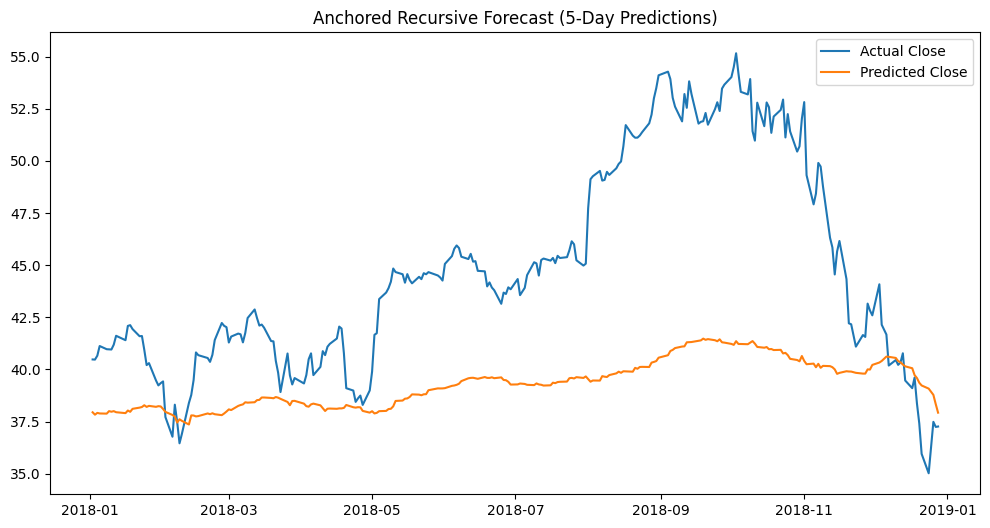

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

# ---------------------- Load & Preprocess AAPL -----------------------
def load_main_stock(path):
    df = pd.read_csv(path, skiprows=3, header=None)
    df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].set_index('Date')
    df = df.loc['2008-01-01':'2024-12-31']

    df['Close_lag1'] = df['Close'].shift(1)
    df['Volume_lag1'] = df['Volume'].shift(1)
    df['ma_5'] = df['Close_lag1'].rolling(window=5).mean()
    df['volatility_63'] = df['Close_lag1'].rolling(window=63).std()
    df['intraday_range'] = df['High'].shift(1) - df['Low'].shift(1)
    df['upper_shadow'] = df['High'].shift(1) - df[['Open', 'Close']].shift(1).max(axis=1)
    df['lower_shadow'] = df[['Open', 'Close']].shift(1).min(axis=1) - df['Low'].shift(1)
    df['momentum_126'] = df['Close_lag1'] - df['Close_lag1'].shift(126)

    df = df.drop(columns=['Open', 'High', 'Low', 'Volume'])
    return df

# ---------------------- Load Related Stocks -----------------------
def load_related_stock(path, prefix):
    df = pd.read_csv(path, skiprows=3, header=None)
    df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df = df.set_index('Date')
    df = df.loc['2008-01-01':'2024-12-31']
    df = df[['Close']]
    df[f'{prefix}_lag1'] = df['Close'].shift(1)
    df = df.drop(columns=['Close'])
    return df

# Main AAPL
df = load_main_stock("AAPL.csv")

# Add related stocks
related_stocks = ['MSFT', 'TSM', 'QCOM', 'AVGO', 'QQQ']
for stock in related_stocks:
    rel_df = load_related_stock(f"{stock}.csv", stock)
    df = df.join(rel_df, how='left')

df = df.dropna()

# ---------------------- Train/Test Split -----------------------
train_df = df.loc['2012-01-01':'2017-12-31']
test_df = df.loc['2017-12-01':'2018-12-31']

features = df.columns.drop('Close')

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(train_df[features])
y_train = scaler_y.fit_transform(train_df[['Close']])
X_test = scaler_X.transform(test_df[features])
y_test = scaler_y.transform(test_df[['Close']])

# ---------------------- Sequence Creation -----------------------
def create_sequences(X, y, window=20, horizon=5):
    Xs, ys = [], []
    for i in range(len(X) - window - horizon + 1):
        Xs.append(X[i:i+window])
        ys.append(y[i+window:i+window+horizon].flatten())
    return np.array(Xs), np.array(ys)

window = 20
horizon = 5
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window, horizon)

# ---------------------- LSTM Model -----------------------
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(128, input_shape=(window, X_train_seq.shape[2]), return_sequences=True,
         dropout=0.2, recurrent_dropout=0.2),
    BatchNormalization(),  # Normalize outputs from the LSTM layer
    LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dropout(0.3),  # Dropout on dense layer to prevent overfitting
    Dense(1, activation='linear')
])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


model.compile(optimizer='adam', loss='mse')
model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, callbacks=[early_stop], verbose=1)

# ---------------------- Recursive Forecast -----------------------
X_test_full = X_test
dates = test_df.index

y_pred_scaled = []
y_pred_dates = []
start = 0

while start + window + horizon <= len(X_test_full):
    current_input = X_test_full[start:start+window].copy()
    pred_dates = dates[start + window : start + window + horizon]

    for i in range(horizon):
        date_i = pred_dates[i]
        if date_i < pd.Timestamp("2018-01-01") or date_i > pd.Timestamp("2018-12-31"):
            continue
        X_input_seq = current_input[-window:].reshape(1, window, -1)
        next_close_scaled = model.predict(X_input_seq, verbose=0)[0][0]
        y_pred_scaled.append([next_close_scaled])
        y_pred_dates.append(date_i)

        real_next_row = df.loc[date_i, features].values.reshape(1, -1)
        real_next_row_scaled = scaler_X.transform(real_next_row)
        real_next_row_scaled[0, features.get_loc('Close_lag1')] = next_close_scaled
        current_input = np.vstack([current_input, real_next_row_scaled])
    start += horizon

# ---------------------- Evaluate and Plot -----------------------
y_pred_scaled = np.array(y_pred_scaled).reshape(-1, 1)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = test_df.loc[y_pred_dates, 'Close']

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")
print(f"MAPE: {mape}")

plt.figure(figsize=(12, 6))
plt.plot(y_true.index, y_true.values, label='Actual Close')
plt.plot(y_true.index, y_pred.flatten(), label='Predicted Close')
plt.legend()
plt.title('Anchored Recursive Forecast (5-Day Predictions)')
plt.show()


window size

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0880
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0054
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0033
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0026
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0024
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0021
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0022
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0022
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0018
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0020
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0018
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0018
Epoch 13/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0018
Epoch 14/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0018
Epoch 15/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0015
Epoc

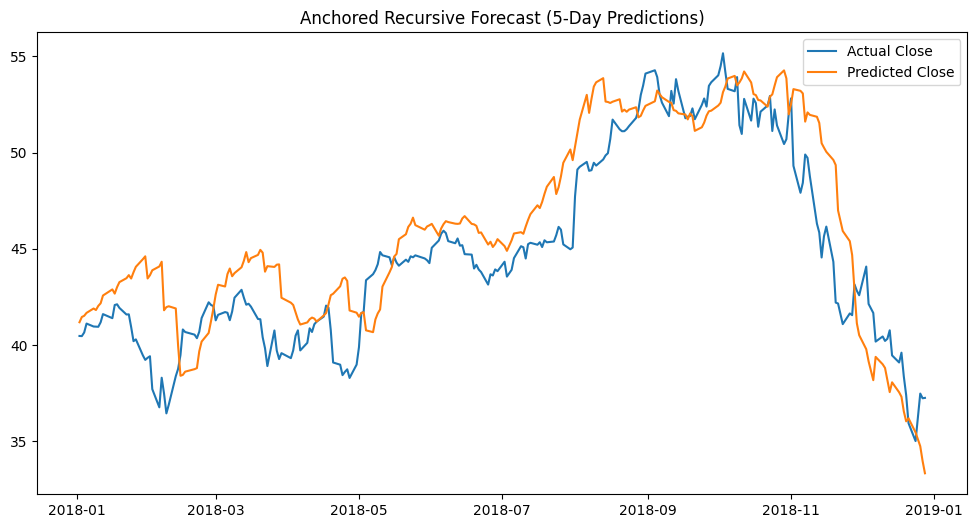

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

# ---------------------- Load & Preprocess AAPL -----------------------
def load_main_stock(path):
    df = pd.read_csv(path, skiprows=3, header=None)
    df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].set_index('Date')
    df = df.loc['2008-01-01':'2024-12-31']

    df['Close_lag1'] = df['Close'].shift(1)
    df['Volume_lag1'] = df['Volume'].shift(1)
    df['ma_5'] = df['Close_lag1'].rolling(window=5).mean()
    df['volatility_63'] = df['Close_lag1'].rolling(window=63).std()
    df['intraday_range'] = df['High'].shift(1) - df['Low'].shift(1)
    df['upper_shadow'] = df['High'].shift(1) - df[['Open', 'Close']].shift(1).max(axis=1)
    df['lower_shadow'] = df[['Open', 'Close']].shift(1).min(axis=1) - df['Low'].shift(1)
    df['momentum_126'] = df['Close_lag1'] - df['Close_lag1'].shift(126)

    df = df.drop(columns=['Open', 'High', 'Low', 'Volume'])
    return df

# ---------------------- Load Related Stocks -----------------------
def load_related_stock(path, prefix):
    df = pd.read_csv(path, skiprows=3, header=None)
    df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df = df.set_index('Date')
    df = df.loc['2008-01-01':'2024-12-31']
    df = df[['Close']]
    df[f'{prefix}_lag1'] = df['Close'].shift(1)
    df = df.drop(columns=['Close'])
    return df

# Main AAPL
df = load_main_stock("AAPL.csv")

# Add related stocks
related_stocks = ['MSFT']
for stock in related_stocks:
    rel_df = load_related_stock(f"{stock}.csv", stock)
    df = df.join(rel_df, how='left')

df = df.dropna()

# ---------------------- Train/Test Split -----------------------
train_df = df.loc['2015-01-01':'2017-12-31']
test_df = df.loc['2017-11-01':'2018-12-31']

features = df.columns.drop('Close')

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(train_df[features])
y_train = scaler_y.fit_transform(train_df[['Close']])
X_test = scaler_X.transform(test_df[features])
y_test = scaler_y.transform(test_df[['Close']])

# ---------------------- Sequence Creation -----------------------
def create_sequences(X, y, window=20, horizon=5):
    Xs, ys = [], []
    for i in range(len(X) - window - horizon + 1):
        Xs.append(X[i:i+window])
        ys.append(y[i+window:i+window+horizon].flatten())
    return np.array(Xs), np.array(ys)

window = 21
horizon = 5
X_train_seq, y_train_seq = create_sequences(X_train, y_train, window, horizon)

# ---------------------- LSTM Model -----------------------
model = Sequential([
    LSTM(128, input_shape=(window, X_train_seq.shape[2])),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=1)

# ---------------------- Recursive Forecast -----------------------
X_test_full = X_test
dates = test_df.index

y_pred_scaled = []
y_pred_dates = []
start = 0

while start + window + horizon <= len(X_test_full):
    current_input = X_test_full[start:start+window].copy()
    pred_dates = dates[start + window : start + window + horizon]

    for i in range(horizon):
        date_i = pred_dates[i]
        if date_i < pd.Timestamp("2018-01-01") or date_i > pd.Timestamp("2018-12-31"):
            continue
        X_input_seq = current_input[-window:].reshape(1, window, -1)
        next_close_scaled = model.predict(X_input_seq, verbose=0)[0][0]
        y_pred_scaled.append([next_close_scaled])
        y_pred_dates.append(date_i)

        real_next_row = df.loc[date_i, features].values.reshape(1, -1)
        real_next_row_scaled = scaler_X.transform(real_next_row)
        real_next_row_scaled[0, features.get_loc('Close_lag1')] = next_close_scaled
        current_input = np.vstack([current_input, real_next_row_scaled])
    start += horizon

# ---------------------- Evaluate and Plot -----------------------
y_pred_scaled = np.array(y_pred_scaled).reshape(-1, 1)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = test_df.loc[y_pred_dates, 'Close']

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")
print(f"MAPE: {mape}")

plt.figure(figsize=(12, 6))
plt.plot(y_true.index, y_true.values, label='Actual Close')
plt.plot(y_true.index, y_pred.flatten(), label='Predicted Close')
plt.legend()
plt.title('Anchored Recursive Forecast (5-Day Predictions)')
plt.show()


multiple layers are worse. backed up by "Predicting stock market index using LSTM".  hyperparams: window size, learning rate,